## Python для Data Science - 2

# Курсовой проект

**Подключение библиотек и скриптов**

In [65]:
import pandas as pd
import numpy as np
import itertools
import random

import warnings
warnings.simplefilter('ignore')

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [66]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [67]:
def balance_df_by_target(df, target_name, balancing_type='oversampling'):
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()
    
    if balancing_type == 'oversampling':
        
        disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)

        return df.sample(frac=1) 
    
    if balancing_type == 'undersampling':
        
        major_class_sample = df[df[target_name] == major_class_name].sample(target_counts[minor_class_name])
        minor_class_sample = df[df[target_name] == minor_class_name]
        
        df = pd.concat([major_class_sample, minor_class_sample], ignore_index=True)
        
        return df.sample(frac=1) 

In [68]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [69]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

**Пути к директориям и файлам**

In [70]:
TRAIN_DATASET_PATH = '../data/course_project_train.csv'
TEST_DATASET_PATH = '../data/course_project_test.csv'
TEST_DATASET_ANS_PATH = '../project_check/course_project_answers.csv'

### Загрузка данных

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - залог
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - кредитный рейтинг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [71]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test_ans = pd.read_csv(TEST_DATASET_ANS_PATH)

### Обзор данных

In [72]:
df_train.iloc[0]

Home Ownership                            Own Home
Annual Income                               482087
Years in current job                           NaN
Tax Liens                                        0
Number of Open Accounts                         11
Years of Credit History                       26.3
Maximum Open Credit                         685960
Number of Credit Problems                        1
Months since last delinquent                   NaN
Bankruptcies                                     1
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                          1e+08
Current Credit Balance                       47386
Monthly Debt                                  7914
Credit Score                                   749
Credit Default                                   0
Name: 0, dtype: object

In [73]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

**Количество пропущенных значений (в процентах)**

In [74]:
round((len(df_train) - df_train.count()) / len(df_train) * 100, 2).sort_values(ascending=False)

Months since last delinquent    54.41
Annual Income                   20.76
Credit Score                    20.76
Years in current job             4.95
Bankruptcies                     0.19
Maximum Open Credit              0.00
Tax Liens                        0.00
Number of Open Accounts          0.00
Years of Credit History          0.00
Credit Default                   0.00
Number of Credit Problems        0.00
Purpose                          0.00
Term                             0.00
Current Loan Amount              0.00
Current Credit Balance           0.00
Monthly Debt                     0.00
Home Ownership                   0.00
dtype: float64

**Количество уникальных значений по каждому из признаков**

In [75]:
df_train.nunique().sort_values()

Credit Default                     2
Term                               2
Home Ownership                     4
Bankruptcies                       5
Tax Liens                          8
Number of Credit Problems          8
Years in current job              11
Purpose                           15
Number of Open Accounts           39
Months since last delinquent      89
Credit Score                     268
Years of Credit History          408
Current Loan Amount             5386
Annual Income                   5478
Current Credit Balance          6592
Monthly Debt                    6716
Maximum Open Credit             6963
dtype: int64

### Приведение типов

In [76]:
df_train.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

### Формирование списков признаков

In [77]:
TARGET_NAME = 'Credit Default'
NUM_FEATURE_NAMES = df_test.select_dtypes(include='float64').columns.tolist()
CAT_FEATURE_NAMES = df_test.select_dtypes(include='object').columns.tolist()

### Анализ целевой переменной

In [78]:
df_train[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

**Количественные признаки в разрезе целевой переменной**

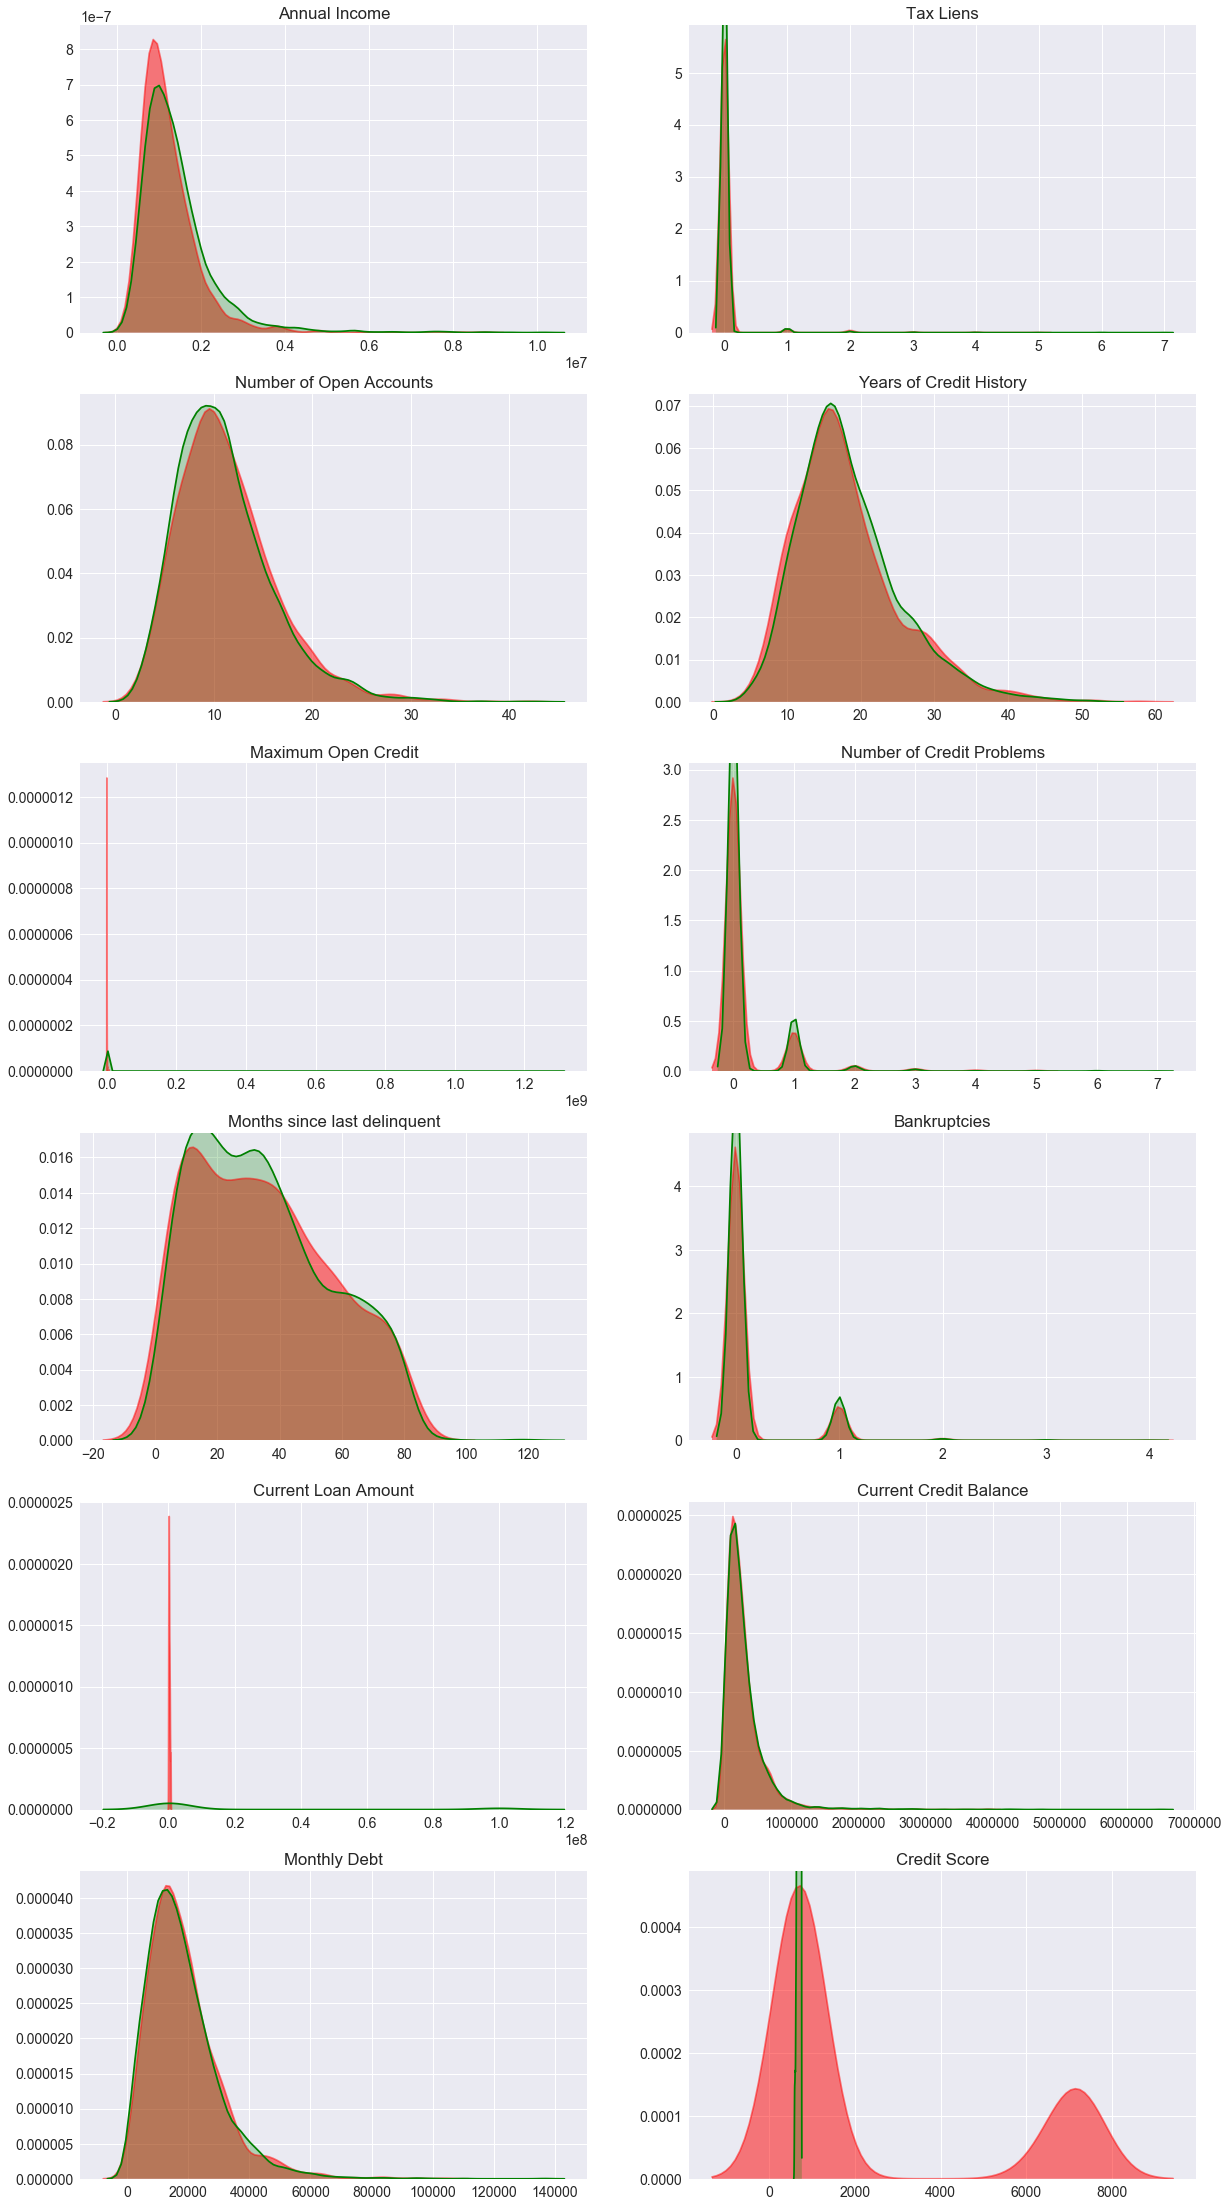

In [79]:
sns.set(font_scale=1.4)
plt.figure(figsize=(20,60))

for i, colname in enumerate(NUM_FEATURE_NAMES):
    plt.subplot(9,2,i+1)
    plt.title(colname)
    sns.kdeplot(df_train.loc[df_train[TARGET_NAME] == 1, colname].dropna(), shade=True, alpha=0.5, legend=False, color='r')
    sns.kdeplot(df_train.loc[df_train[TARGET_NAME] == 0, colname].dropna(), shade=True, legend=False, color='g')
    
plt.show()

**Категориальные признаки в разрезе целевой переменной**

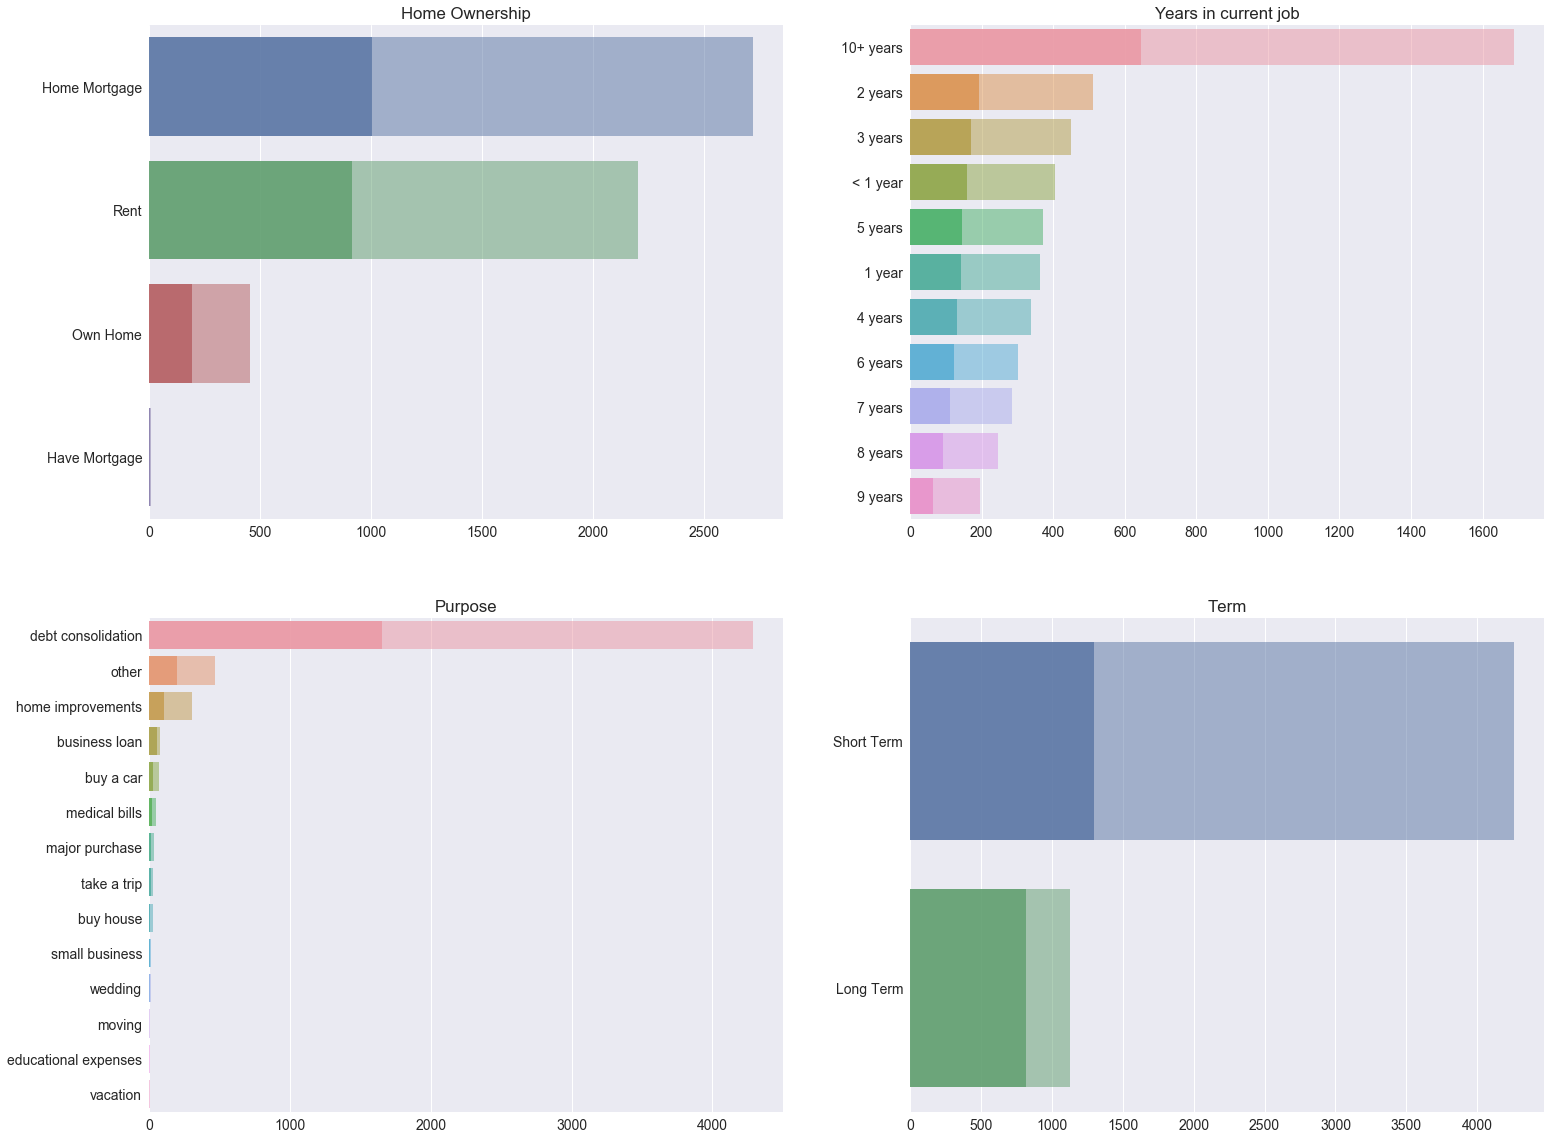

In [82]:
sns.set(font_scale=1.4)
plt.figure(figsize=(25,20))

for i, colname in enumerate(CAT_FEATURE_NAMES):
    plt.subplot(2,2,i+1)
    plt.title(colname)
    
    val_counts_t1 = df_train.loc[df_train[TARGET_NAME] == 1, colname].value_counts()
    val_counts_t0 = df_train.loc[df_train[TARGET_NAME] == 0, colname].value_counts()
    
    sns.barplot(val_counts_t1.values, val_counts_t1.index, alpha=0.8)
    sns.barplot(val_counts_t0.values, val_counts_t0.index, alpha=0.5)
    
plt.show()

**Оценка корреляций с целевой переменной**

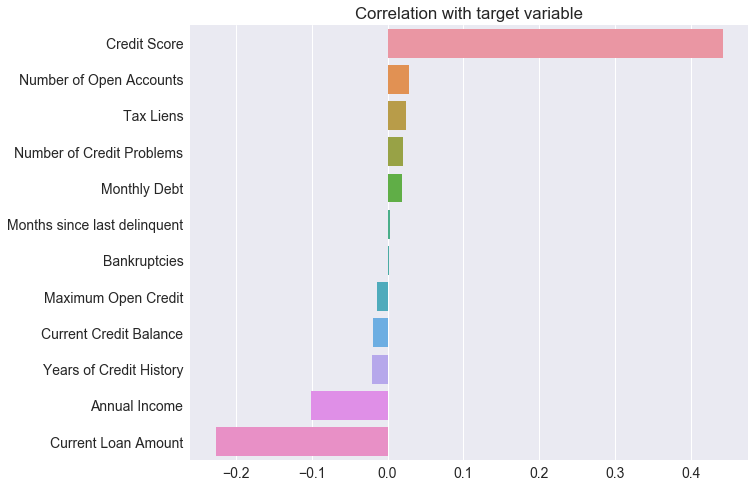

In [17]:
corr_with_target = df_train.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

### Анализ линейных зависимостей в признаковом пространстве

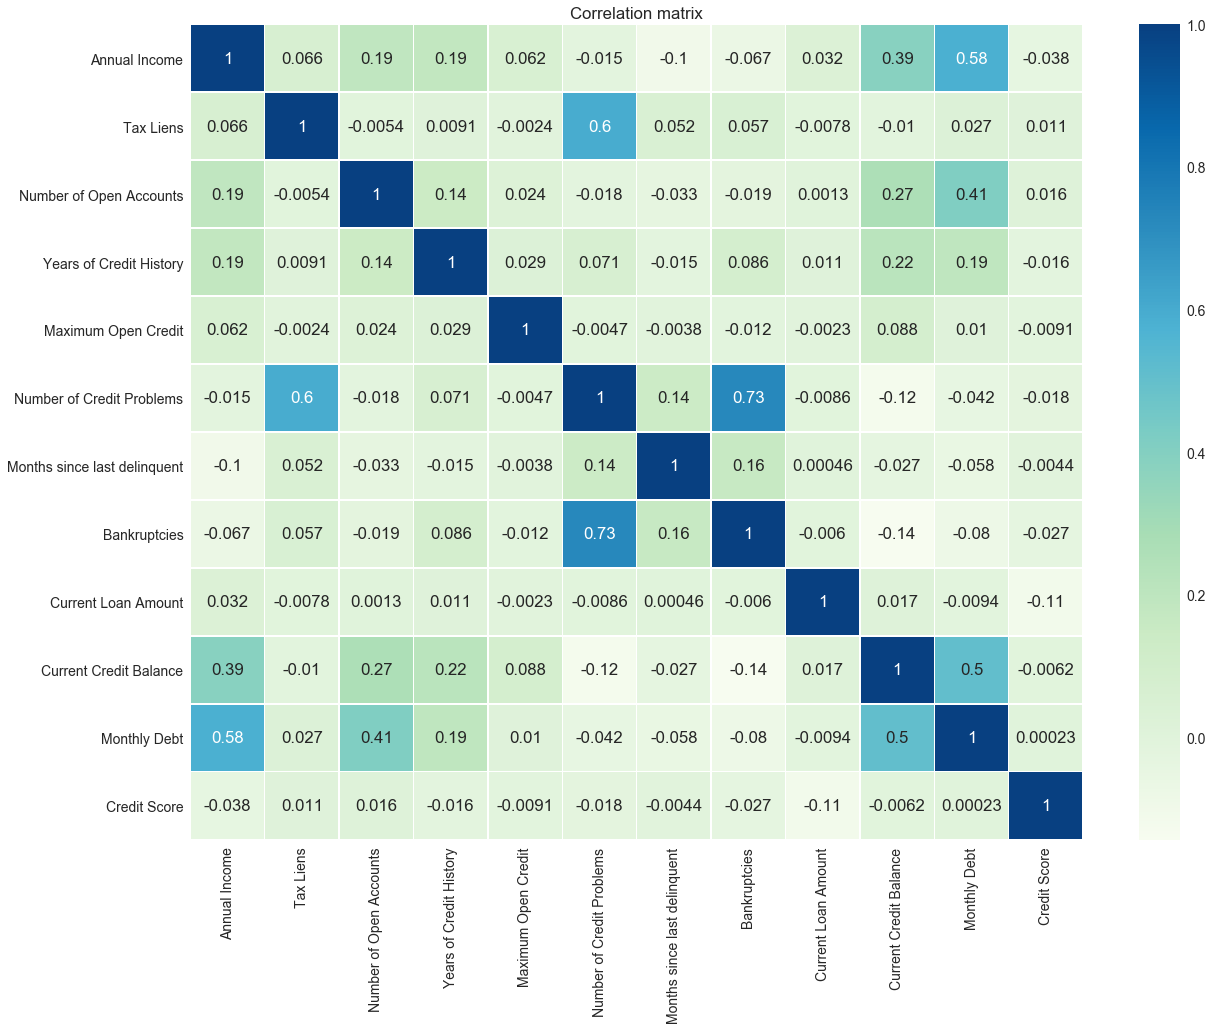

In [18]:
plt.figure(figsize=(20,15))

sns.set(font_scale=1.4)
sns.heatmap(df_train.drop(columns=TARGET_NAME).corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

### Устранение выбросов

In [19]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


**Annual Income**

In [20]:
df_train['Annual Income'].max()

10149344.0

In [21]:
df_train['Annual Income'].quantile(.99)

4517246.579999999

In [22]:
df_train.loc[df_train['Annual Income'] < 4000000, 'Credit Default'].value_counts()

0    4279
1    1573
Name: Credit Default, dtype: int64

In [23]:
df_train.loc[df_train['Annual Income'] >= 4000000, 'Credit Default'].value_counts()

0    80
1    11
Name: Credit Default, dtype: int64

In [24]:
df_train.loc[df_train['Annual Income'] > 4000000, 'Annual Income'] = 4000000
df_test.loc[df_test['Annual Income'] > 4000000, 'Annual Income'] = 4000000

**Number of Open Accounts**

**Years of Credit History**

**Maximum Open Credit**

*Нулевые значения*

In [25]:
df_train.loc[df_train['Maximum Open Credit'] == 0, 'Credit Default'].value_counts()

0    55
1    10
Name: Credit Default, dtype: int64

*Очень большие значения*

In [26]:
df_train['Maximum Open Credit'].quantile(.99)

3568459.40000001

In [27]:
df_train.loc[df_train['Maximum Open Credit'] > 5000000, 'Maximum Open Credit'] = 5000000
df_test.loc[df_test['Maximum Open Credit'] > 5000000, 'Maximum Open Credit'] = 5000000

In [28]:
df_train.loc[df_train['Maximum Open Credit'] == 5000000, 'Credit Default'].value_counts()

0    46
1     6
Name: Credit Default, dtype: int64

**Current Loan Amount**

In [29]:
df_train.loc[df_train['Current Loan Amount'] == 99999999, 'Credit Default'].value_counts()

0    870
Name: Credit Default, dtype: int64

In [30]:
df_train.loc[df_train['Current Loan Amount'] != 99999999, 'Credit Default'].value_counts()

0    4517
1    2113
Name: Credit Default, dtype: int64

In [31]:
df_train.loc[df_train['Current Loan Amount'] == 99999999, 'Current Loan Amount'] = 1000000
df_test.loc[df_test['Current Loan Amount'] == 99999999, 'Current Loan Amount'] = 1000000

**Credit Score**

In [32]:
df_train.loc[df_train['Credit Default'] == 0, 'Credit Score'].sort_values().unique()

array([590., 594., 597., 598., 601., 602., 606., 608., 609., 610., 611.,
       612., 613., 617., 618., 621., 622., 624., 625., 626., 627., 628.,
       629., 631., 632., 634., 635., 636., 637., 638., 639., 640., 642.,
       643., 644., 645., 646., 647., 648., 649., 650., 651., 652., 653.,
       654., 655., 656., 657., 658., 659., 660., 661., 662., 663., 664.,
       665., 666., 667., 668., 669., 670., 671., 672., 673., 674., 675.,
       676., 677., 678., 679., 680., 681., 682., 683., 684., 685., 686.,
       687., 688., 689., 690., 691., 692., 693., 694., 695., 696., 697.,
       698., 699., 700., 701., 702., 703., 704., 705., 706., 707., 708.,
       709., 710., 711., 712., 713., 714., 715., 716., 717., 718., 719.,
       720., 721., 722., 723., 724., 725., 726., 727., 728., 729., 730.,
       731., 732., 733., 734., 735., 736., 737., 738., 739., 740., 741.,
       742., 743., 744., 745., 746., 747., 748., 749., 750., 751.,  nan])

In [33]:
df_train.loc[df_train['Credit Default'] == 1, 'Credit Score'].sort_values().unique()

array([ 585.,  586.,  588.,  589.,  591.,  593.,  594.,  599.,  601.,
        604.,  607.,  608.,  611.,  612.,  613.,  614.,  615.,  616.,
        617.,  619.,  620.,  621.,  622.,  624.,  625.,  626.,  627.,
        628.,  630.,  633.,  635.,  636.,  637.,  638.,  639.,  640.,
        642.,  643.,  644.,  645.,  646.,  647.,  648.,  649.,  650.,
        651.,  652.,  653.,  654.,  655.,  656.,  657.,  658.,  659.,
        660.,  661.,  662.,  663.,  664.,  665.,  666.,  667.,  668.,
        669.,  670.,  671.,  672.,  673.,  674.,  675.,  676.,  677.,
        678.,  679.,  680.,  681.,  682.,  683.,  684.,  685.,  686.,
        687.,  688.,  689.,  690.,  691.,  692.,  693.,  694.,  695.,
        696.,  697.,  698.,  699.,  700.,  701.,  702.,  703.,  704.,
        705.,  706.,  707.,  708.,  709.,  710.,  711.,  712.,  713.,
        714.,  715.,  716.,  717.,  718.,  719.,  720.,  721.,  722.,
        723.,  724.,  725.,  726.,  727.,  728.,  729.,  730.,  731.,
        732.,  733.,

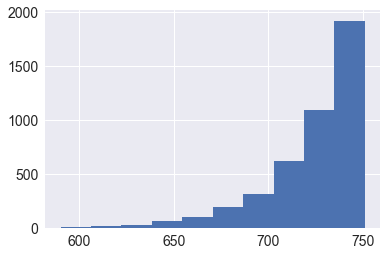

In [34]:
df_train.loc[df_train['Credit Default'] == 0, 'Credit Score'].hist();

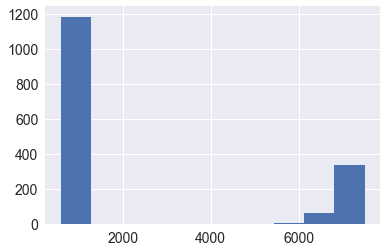

In [35]:
df_train.loc[df_train['Credit Default'] == 1, 'Credit Score'].hist();

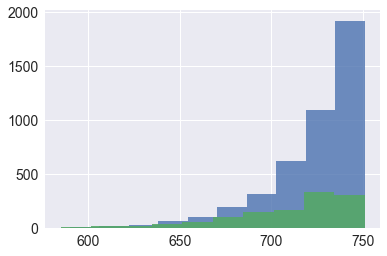

In [36]:
df_train.loc[(df_train['Credit Score'] < 1000) & (df_train['Credit Default'] == 0), 'Credit Score'].hist(alpha=0.8);
df_train.loc[(df_train['Credit Score'] < 1000) & (df_train['Credit Default'] == 1), 'Credit Score'].hist(alpha=0.9);

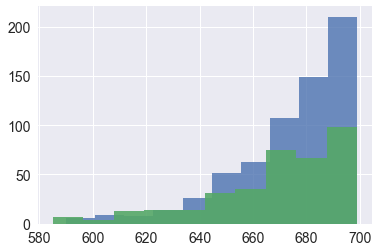

In [37]:
df_train.loc[(df_train['Credit Score'] < 700) & (df_train['Credit Default'] == 0), 'Credit Score'].hist(alpha=0.8);
df_train.loc[(df_train['Credit Score'] < 700) & (df_train['Credit Default'] == 1), 'Credit Score'].hist(alpha=0.9);

In [38]:
df_train['Credit Score Bin'] = 0
df_train.loc[(df_train['Credit Score'] <= 670) | (df_train['Credit Score'] >= 1000), 'Credit Score Bin'] = 1

df_test['Credit Score Bin'] = 0
df_test.loc[(df_test['Credit Score'] <= 670) | (df_test['Credit Score'] >= 1000), 'Credit Score Bin'] = 1

### Устранение пропусков

**Annual Income**

In [39]:
features_for_lr = ['Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems',
                   'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt']

In [40]:
df_train_ai = df_train[df_train['Annual Income'].notnull()]

In [41]:
scaler = StandardScaler()

X_ai = scaler.fit_transform(df_train_ai[features_for_lr])
y_ai = df_train_ai['Annual Income']

model_lr_ai = LinearRegression()
model_lr_ai.fit(X_ai, y_ai)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [42]:
pd.DataFrame(zip(model_lr_ai.coef_, features_for_lr), columns=['coef', 'feature_name']).sort_values(by='coef', ascending=False)

,coef,feature_name
6,404507.166175,Monthly Debt
2,113561.922464,Maximum Open Credit
4,98560.689992,Current Loan Amount
1,50322.781118,Years of Credit History
3,15283.515256,Number of Credit Problems
5,-10763.774468,Current Credit Balance
0,-74412.570195,Number of Open Accounts


**Credit Score**

In [43]:
df_train_cs = df_train[df_train['Credit Score'].notnull()]

In [44]:
scaler = StandardScaler()

X_cs = scaler.fit_transform(df_train_cs[features_for_lr])
y_cs = df_train_cs['Credit Score']

model_lr_cs = LinearRegression()
model_lr_cs.fit(X_cs, y_cs)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [45]:
pd.DataFrame(zip(model_lr_cs.coef_, features_for_lr), columns=['coef', 'feature_name']).sort_values(by='coef', ascending=False)

,coef,feature_name
5,69.733965,Current Credit Balance
0,55.611734,Number of Open Accounts
6,8.705059,Monthly Debt
1,-12.143790,Years of Credit History
3,-35.504093,Number of Credit Problems
2,-95.135899,Maximum Open Credit
4,-130.685653,Current Loan Amount


**Months since last delinquent**

In [46]:
df_train.loc[df_train['Months since last delinquent'].isnull(), 'Credit Default'].value_counts()

0    2951
1    1130
Name: Credit Default, dtype: int64

In [47]:
df_train.loc[df_train['Months since last delinquent'].notnull(), 'Credit Default'].value_counts()

0    2436
1     983
Name: Credit Default, dtype: int64

**Количественные признаки**

In [48]:
for colname in NUM_FEATURE_NAMES:
    df_train[colname].fillna(df_train[colname].median(), inplace=True)
    df_test[colname].fillna(df_test[colname].median(), inplace=True)

**Категориальные признаки**

In [49]:
for colname in CAT_FEATURE_NAMES:
    df_train[colname].fillna(df_train[colname].mode()[0], inplace=True)
    df_test[colname].fillna(df_test[colname].mode()[0], inplace=True)

### Корректировка значений и построение новых признаков

**Term**

In [50]:
df_train['Is Short Term'] = df_train['Term'].replace({'Short Term':1, 'Long Term':0})
df_test['Is Short Term'] = df_test['Term'].replace({'Short Term':1, 'Long Term':0})

**Home Ownership**

In [51]:
df_train.loc[df_train['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'
df_test.loc[df_test['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'

In [52]:
df_train = pd.concat([df_train, pd.get_dummies(df_train['Home Ownership'], prefix='Home Ownership')], axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test['Home Ownership'], prefix='Home Ownership')], axis=1)

In [53]:
df_train['Home Ownership'].value_counts()

Home Mortgage    3649
Rent             3204
Own Home          647
Name: Home Ownership, dtype: int64

In [54]:
df_train.drop(columns='Home Ownership_Own Home', inplace=True)
df_test.drop(columns='Home Ownership_Own Home', inplace=True)

**Tax Liens**

In [55]:
replace_dict = {0:0, 1:1, 2:2, 3:2, 4:2, 5:2, 6:3, 7:3}

df_train['Tax Liens'].replace(replace_dict, inplace=True)
df_test['Tax Liens'].replace(replace_dict, inplace=True)

**Years in current job**

In [56]:
replace_dict = {'< 1 year':0, '1 year':1, '2 years':2, '3 years':3, '4 years':4, '5 years':5,
                '6 years':6, '7 years':7, '8 years':8, '9 years':9, '10+ years':10}

df_train['Years in current job'].replace(replace_dict, inplace=True)
df_test['Years in current job'].replace(replace_dict, inplace=True)

In [57]:
NUM_FEATURE_NAMES.append('Years in current job')

**Purpose**

In [58]:
df_train['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [59]:
important_purpose = ['debt consolidation', 'other', 'home improvements', 'business loan', 'buy a car']

df_train.loc[~df_train['Purpose'].isin(important_purpose), 'Purpose'] = 'other'
df_test.loc[~df_test['Purpose'].isin(important_purpose), 'Purpose'] = 'other'

In [60]:
df_train = pd.concat([df_train, pd.get_dummies(df_train['Purpose'], prefix='Purpose')], axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test['Purpose'], prefix='Purpose')], axis=1)

In [61]:
df_train['Purpose'].value_counts()

debt consolidation    5944
other                  919
home improvements      412
business loan          129
buy a car               96
Name: Purpose, dtype: int64

In [62]:
df_train.drop(columns='Purpose_other', inplace=True)
df_test.drop(columns='Purpose_other', inplace=True)

**Bankruptcies and Number of Credit Problems**

**Annual Income Cat**

In [63]:
df_train['Annual Income Cat'] = pd.cut(df_train['Annual Income'], 5, labels=[0, 1, 2, 3, 5])
df_test['Annual Income Cat'] = pd.cut(df_test['Annual Income'], 5, labels=[0, 1, 2, 3, 5])

df_train['Annual Income Cat'].value_counts()

1    4245
0    1881
2     922
3     269
5     183
Name: Annual Income Cat, dtype: int64

**Главные компоненты**

In [64]:
important_features = ['Annual Income', 'Current Loan Amount', 'Credit Score', 'Maximum Open Credit', 'Monthly Debt']

In [65]:
n = 3
component_names = ['component_' + str(i+1) for i in range(n)]

In [66]:
pca = PCA(n_components=n)

train_components = pca.fit_transform(df_train[important_features])
train_components = pd.DataFrame(data=train_components, columns=component_names)

In [67]:
pca = PCA(n_components=n)

test_components = pca.fit_transform(df_test[important_features])
test_components = pd.DataFrame(data=test_components, columns=component_names)

In [68]:
df_train = pd.concat([df_train, train_components], axis=1)
df_test = pd.concat([df_test, test_components], axis=1)

In [69]:
NUM_FEATURE_NAMES.extend(component_names)

**Производные признаки**

**Комбинации признаков**

### Отбор признаков

In [70]:
SELECTED_FEATURE_NAMES = df_train.columns.drop(['Home Ownership', 'Purpose', 'Term'] +
                                               [TARGET_NAME]).tolist()

In [71]:
SELECTED_FEATURE_NAMES

['Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Score Bin',
 'Is Short Term',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Rent',
 'Purpose_business loan',
 'Purpose_buy a car',
 'Purpose_debt consolidation',
 'Purpose_home improvements',
 'Annual Income Cat',
 'component_1',
 'component_2',
 'component_3']

In [72]:
df_train = df_train[SELECTED_FEATURE_NAMES + [TARGET_NAME]]
df_test = df_test[SELECTED_FEATURE_NAMES]

### Нормализация данных

### Разбиение на train и test

In [86]:
X = df_train.drop(columns=TARGET_NAME)
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=21)

### Балансировка целевой переменной

**Расчет весов для классов**

In [87]:
compute_class_weight('balanced', np.array([0, 1]), df_train[TARGET_NAME])

array([0.69612029, 1.77472788])

**Балансировка методом Oversampling**

**Балансировка методом Undersampling**

### Базовая модель

In [88]:
%%time
model_catb = catb.CatBoostClassifier(class_weights=[0.7, 1.8], silent=True, random_state=21, 
                                     cat_features=['Annual Income Cat'])
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      3771
           1       0.83      0.94      0.88      1479

    accuracy                           0.93      5250
   macro avg       0.90      0.93      0.92      5250
weighted avg       0.93      0.93      0.93      5250

TEST

              precision    recall  f1-score   support

           0       0.82      0.78      0.80      1616
           1       0.50      0.56      0.53       634

    accuracy                           0.72      2250
   macro avg       0.66      0.67      0.66      2250
weighted avg       0.73      0.72      0.72      2250

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0               1258  358
1                279  355
CPU times: user 49 s, sys: 7.01 s, total: 56 s
Wall time: 19.6 s


### Подбор гиперпараметров

In [84]:
X_train

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,...,Home Ownership_Home Mortgage,Home Ownership_Rent,Purpose_business loan,Purpose_buy a car,Purpose_debt consolidation,Purpose_home improvements,Annual Income Cat,component_1,component_2,component_3
3910,682898.0,10,0.0,9.0,29.5,565664.0,0.0,10.0,0.0,175714.0,...,1,0,0,0,1,0,0,-5.319645e+05,3.757907e+05,130837.432768
3689,786353.0,10,0.0,9.0,9.6,160490.0,0.0,32.0,0.0,216788.0,...,1,0,0,0,1,0,0,-7.285668e+05,8.575364e+03,75716.979286
4452,1158354.0,2,0.0,11.0,23.0,225412.0,0.0,14.0,0.0,223542.0,...,0,1,0,0,1,0,1,-4.159260e+05,-1.991983e+05,118195.710826
6971,1168595.0,10,0.0,15.0,17.5,536998.0,0.0,32.0,0.0,450516.0,...,1,0,0,0,1,0,1,-1.657597e+05,1.275086e+04,-84676.590896
2982,1168386.0,5,0.0,9.0,11.4,203390.0,0.0,32.0,0.0,21626.0,...,1,0,0,0,0,0,1,-4.508443e+05,-2.150534e+05,317966.963656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48,1168386.0,8,0.0,14.0,18.7,252670.0,0.0,29.0,0.0,323796.0,...,1,0,0,0,0,1,1,-3.767726e+05,-1.896934e+05,21920.095159
772,1168386.0,10,0.0,8.0,16.9,694562.0,0.0,32.0,0.0,492118.0,...,1,0,0,0,1,0,1,-5.284024e+04,1.261421e+05,-115444.043390
5944,2365367.0,5,0.0,16.0,23.6,3007136.0,0.0,32.0,0.0,152152.0,...,1,0,0,1,0,0,2,2.340577e+06,1.001332e+06,519188.957640
5327,855969.0,10,0.0,10.0,22.0,484990.0,0.0,32.0,0.0,495022.0,...,1,0,0,0,1,0,0,-4.200109e+05,1.874648e+05,-169920.836930


In [89]:
%%time
model_catb = catb.CatBoostClassifier(max_depth=4,
                                     class_weights=[0.7, 1.8], silent=True, random_state=21, 
                                     cat_features=['Annual Income Cat'])
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)
y_test_pred_probs = model_catb.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.93      0.84      0.88      3771
           1       0.66      0.83      0.74      1479

    accuracy                           0.83      5250
   macro avg       0.80      0.83      0.81      5250
weighted avg       0.85      0.83      0.84      5250

TEST

              precision    recall  f1-score   support

           0       0.83      0.74      0.78      1616
           1       0.48      0.63      0.55       634

    accuracy                           0.71      2250
   macro avg       0.66      0.68      0.66      2250
weighted avg       0.74      0.71      0.72      2250

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0               1193  423
1                237  397
CPU times: user 39.3 s, sys: 7.09 s, total: 46.4 s
Wall time: 16.2 s


### Важность признаков

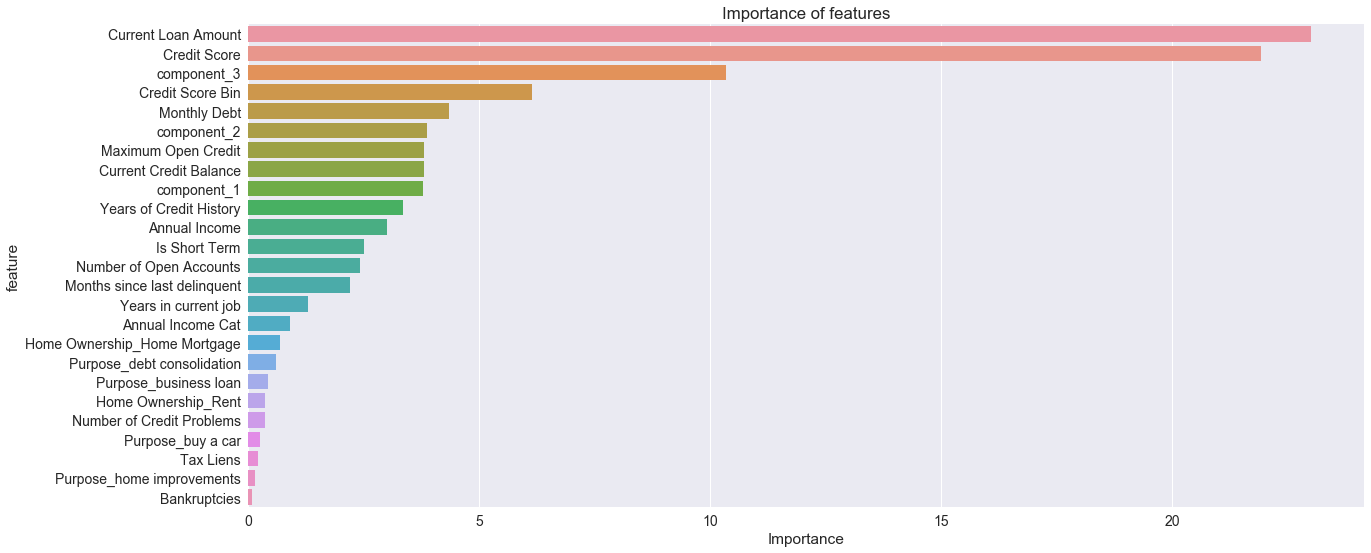

In [90]:
show_feature_importances(X.columns, model_catb.feature_importances_)

### Выбор порога вероятности для определения класса

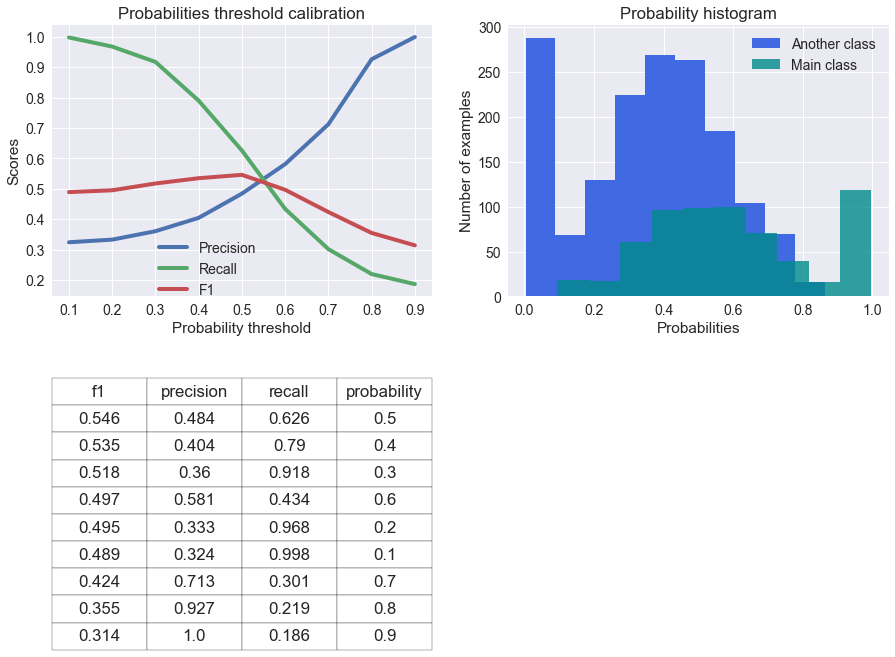

In [91]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

### Обучение финальной модели и оценка результатов

In [92]:
%%time
final_model = catb.CatBoostClassifier(max_depth=4,
                                      class_weights=[0.7, 1.8], silent=True, random_state=21, 
                                     cat_features=['Annual Income Cat'])
final_model.fit(X, y)

y_pred = final_model.predict(df_test)
y_pred_probs = final_model.predict_proba(df_test)

CPU times: user 41.8 s, sys: 6.03 s, total: 47.9 s
Wall time: 14.8 s


*Model labels*

In [93]:
print(classification_report(df_test_ans['Credit Default'], y_pred))

              precision    recall  f1-score   support

           0       0.83      0.76      0.79      1788
           1       0.50      0.60      0.54       712

    accuracy                           0.71      2500
   macro avg       0.66      0.68      0.67      2500
weighted avg       0.73      0.71      0.72      2500



In [94]:
f1_score(df_test_ans['Credit Default'], y_pred)

0.5440710209258084

*Custom labels*

In [95]:
prob_threshold = 0.47
print(classification_report(df_test_ans['Credit Default'], (y_pred_probs[:, 1] > prob_threshold).astype(int)))

              precision    recall  f1-score   support

           0       0.84      0.70      0.77      1788
           1       0.47      0.67      0.56       712

    accuracy                           0.69      2500
   macro avg       0.66      0.69      0.66      2500
weighted avg       0.74      0.69      0.71      2500



In [96]:
f1_score(df_test_ans['Credit Default'], (y_pred_probs[:, 1] > prob_threshold).astype(int))

0.5550405561993047

### Что ещё можно попробовать

1. Подойти более детально к построению моделей для прогнозирования пропусков в признаках 
2. Кластеризация, добавить кластеры, как новый признак
3. Стекинг моделей для построения прогнозов